In [118]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit import ClassicalRegister
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [119]:
# runtime imports
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)

In [120]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2
from qiskit_aer import QasmSimulator, AerSimulator

backend = QasmSimulator()

In [121]:
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
# )

hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980)]
)

print(hamiltonian)

SparsePauliOp(['YZ'],
              coeffs=[0.398+0.j])


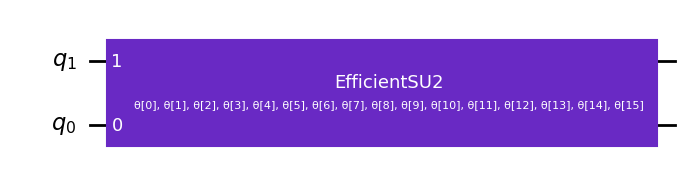

In [122]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw()

In [123]:
num_params = ansatz.num_parameters

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [124]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [125]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    if cost_history_dict['iters'] == 0:    
        # ansatz.h(0)
        # ansatz.sdg(0)
        # ansatz.cx(0,1)
        cr = ClassicalRegister(1, name='cr')
        ansatz.add_register(cr)
        ansatz.measure(1,0)
    
    # print(cost_history_dict['iters'])
    # print(ansatz)
    sampler = SamplerV2(backend=AerSimulator())

    job = sampler.run([(ansatz, params, 1000)])
    counts = job.result()[0].data.cr.get_counts()
    print(counts)
    total = sum(counts.values())
    print(total)
    probabilities = { state: count/total for state, count in counts.items() }
    
    print(probabilities)
    if '0' in probabilities and '1' in probabilities:
        energy = (probabilities['0'] - probabilities['1']) * 0.3980
    elif '0' in probabilities:
        energy = probabilities['0'] * 0.3980
    elif '1' in probabilities:
        energy = -probabilities['1'] * 0.3980
    print(energy)

    # pub = (ansatz, [hamiltonian], [params])
    # result = estimator.run(pubs=[pub]).result()
    # energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [126]:
x0 = 2 * np.pi * np.random.random(num_params)

In [127]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

{'0': 545, '1': 455}
1000
{'0': 0.545, '1': 0.455}
0.03582000000000001
Iters. done: 1 [Current cost: 0.03582000000000001]
{'1': 181, '0': 819}
1000
{'1': 0.181, '0': 0.819}
0.253924
Iters. done: 2 [Current cost: 0.253924]
{'0': 588, '1': 412}
1000
{'0': 0.588, '1': 0.412}
0.070048
Iters. done: 3 [Current cost: 0.070048]
{'0': 586, '1': 414}
1000
{'0': 0.586, '1': 0.414}
0.068456
Iters. done: 4 [Current cost: 0.068456]
{'1': 432, '0': 568}
1000
{'1': 0.432, '0': 0.568}
0.05412799999999998
Iters. done: 5 [Current cost: 0.05412799999999998]
{'1': 825, '0': 175}
1000
{'1': 0.825, '0': 0.175}
-0.2587
Iters. done: 6 [Current cost: -0.2587]
{'1': 954, '0': 46}
1000
{'1': 0.954, '0': 0.046}
-0.361384
Iters. done: 7 [Current cost: -0.361384]
{'1': 915, '0': 85}
1000
{'1': 0.915, '0': 0.085}
-0.33034
Iters. done: 8 [Current cost: -0.33034]
{'0': 169, '1': 831}
1000
{'0': 0.169, '1': 0.831}
-0.263476
Iters. done: 9 [Current cost: -0.263476]
{'0': 42, '1': 958}
1000
{'0': 0.042, '1': 0.958}
-0.364

In [128]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.39004
       x: [ 4.541e+00  3.161e+00 ...  1.486e+00  1.712e+00]
    nfev: 147
   maxcv: 0.0


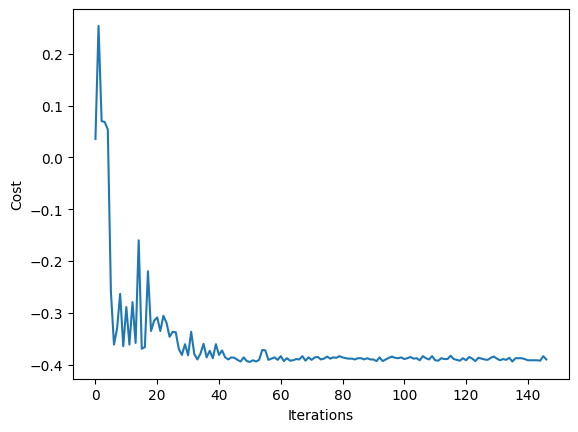

In [129]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()